### Exploração de modelos de predição:
* Aplicação de Pipeline (sklearn)
* Modelos Decision Tree e XGBoost
* Pycaret
* Avaliação e Matriz de confusão

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix

In [2]:
df_credit = pd.read_csv('corporating_credit_data/corporate_rating_train.csv')
df_credit.head(2)

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,effectiveTaxRate,freeCashFlowOperatingCashFlowRatio,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover
0,BBB,RPM International Inc.,RPM,Egan-Jones Ratings Company,8/20/2015,Basic Industries,2.324803,1.252078,0.193428,75.963264,...,-57.510867,0.741675,1.886241,1.344624,3.635023,-0.000851,23.162414,2.543218,0.071922,5.180325
1,A,Broadcom Inc.,AVGO,Moody's Investors Service,6/15/2012,Technology,3.980000,3.305714,2.368571,51.250000,...,0.016043,0.845730,2.501165,3.376980,1.219342,0.241866,10.002166,2.957403,0.310788,5.380090


In [3]:
# According to Standard & Poor's (S&P)
# S&P Global is a services company that creates financial indices and provides credit ratings
risk_dict = {'AAA': 'Lowest Risk',
             'AA': 'Low Risk',
             'A': 'Low Risk',
             'BBB': 'Medium Risk',
             'BB': 'High Risk',
             'B': 'High Risk',
             'CCC': 'Highest Risk',
             'CC': 'Highest Risk',
             'C': 'Highest Risk',
             'D': 'Highest Risk'}

In [4]:
# Map the ratings to numerical values
df_credit['Rating_id'] = df_credit['Rating'].map(risk_dict)

In [5]:
le = LabelEncoder()
df_credit["Rating_id_encoded"] = le.fit_transform(df_credit["Rating_id"])

In [6]:
df_credit['Rating_id_encoded'].unique()

array([4, 2, 0, 1, 3])

In [7]:
# Drop unnecessary columns and previous rating, rating_id column
df_credit = df_credit.drop(columns=['Name', 'Symbol', 'Rating', 'Rating_id', 'Rating Agency Name', 'Date'])

In [8]:
categorical_features = df_credit.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = df_credit.select_dtypes(include=["int64", "float64"]).columns.tolist()

In [9]:
# Define the preprocessor for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Define the model with class weights to handle class imbalance
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42,
    class_weight="balanced"
)

# Create a pipeline that combines the preprocessor and the model
pipe = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", model)
])

Obs: Não é preciso normalisar os dados para os modelos de Xgboost e decision trees

(https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost)

(https://github.com/dmlc/xgboost/issues/357)

In [10]:
# Split the data into features and target variable
data_X = df_credit.drop(columns=['Rating_id_encoded'])
data_y = df_credit['Rating_id_encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_X, data_y, test_size=0.2, random_state=42, stratify=data_y
)

In [11]:
X_test.to_csv("Test_data.csv")

In [12]:
# Fit the pipeline to the training data and train the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['currentRatio', 'quickRatio',
                                                   'cashRatio',
                                                   'daysOfSalesOutstanding',
                                                   'netProfitMargin',
                                                   'pretaxProfitMargin',
                                                   'grossProfitMargin',
                                                   'operatingProfitMargin',
                                                   'returnOnAssets',
                                                   'returnOnCapitalEmployed',
                                                   'returnOnEquity',
                                                   'assetTurnover',
                                                   'fixedAssetTurnover',
                                                   'debtEquityRatio',
                                                   'de...
                                                   'freeCashFlowPerShare',
                                                   'cashPerShare',
                                                   'companyEquityMultiplier',
                                                   'ebitPerRevenue',
                                                   'enterpriseValueMultiple',
                                                   'operatingCashFlowPerShare',
                                                   'operatingCashFlowSalesRatio',
                                                   'payablesTurnover']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sector'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=20,
                                        n_estimators=300, random_state=42))])

In [13]:
# Make predictions on the test set
y_pred = pipe.predict(X_test)


In [14]:
# Evaluate the model and print the accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.6646153846153846
              precision    recall  f1-score   support

   High Risk       0.64      0.80      0.71       127
Highest Risk       0.00      0.00      0.00        11
    Low Risk       0.81      0.71      0.76        79
 Lowest Risk       0.00      0.00      0.00         1
 Medium Risk       0.61      0.55      0.58       107

    accuracy                           0.66       325
   macro avg       0.41      0.41      0.41       325
weighted avg       0.65      0.66      0.65       325



c:\Users\Natalia\anaconda3\envs\cerc\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natalia\anaconda3\envs\cerc\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Natalia\anaconda3\envs\cerc\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


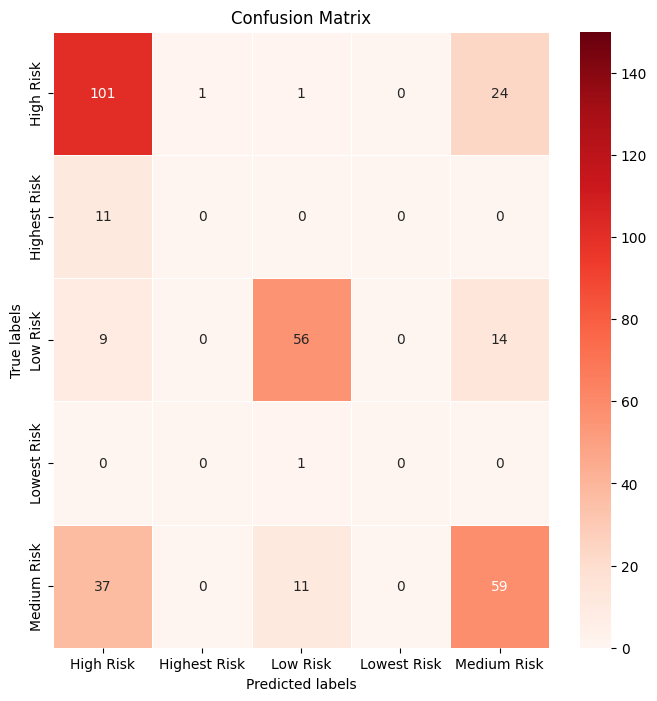

In [15]:
# Create a confusion matrix and display it with seaborn heatmap
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm_df, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 


In [16]:
import pandas as pd
import numpy as np

# nomes das features numéricas
num_features = numeric_features

# nomes das features categóricas após OneHot
cat_features = pipe.named_steps["preprocess"].named_transformers_["cat"].get_feature_names_out(categorical_features)

# todas as features
all_features = np.concatenate([num_features, cat_features])
importances = pipe.named_steps["model"].feature_importances_

fi = pd.Series(importances, index=all_features).sort_values(ascending=False)

# Features Numéricas → mantidas como estão
# Features Categóricas → somar todas as dummies da mesma coluna original

def aggregate_feature_importance(fi_raw, numeric_features, categorical_features):
    aggregated = {}

    # Numéricas (1 para 1)
    for col in numeric_features:
        aggregated[col] = fi_raw.get(col, 0)

    # Categóricas (somar dummies)
    for col in categorical_features:
        mask = fi_raw.index.str.startswith(col + "_")
        aggregated[col] = fi_raw[mask].sum()

    return (
        pd.Series(aggregated).sort_values(ascending=False)
    )

fi_agg = aggregate_feature_importance(fi, numeric_features, categorical_features)

In [17]:
import plotly.express as px

fig = px.bar(
    fi_agg.head(10)[::-1],
    orientation="h",
    title="Top 20 Feature Importances (Random Forest)"
)

fig.update_layout(
    xaxis_title="Importance",
    yaxis_title="Feature"
)

fig.show()


O primeiro modelo treinado obteve uma acurácia de 0.68. No entanto, investgando o resultado do feature importance plot pode-se notar que a coluna de maior importancia era "Symbol" -> o simbolo (nome) da empresa. A coluna fo removida e modelo retreinado, a acurácia abaixou para 0.63.

### Exploração de outros modelos utilizando a ferramenta Pycaret

In [18]:
from pycaret.classification import *

In [19]:
from pycaret.classification import setup

#Pycaret deals wth categorcal values, so we don't need to encode the daata
clf1 = setup(data = X_train, target = y_train)

,Description,Value
0,Session id,1742
1,Target,Rating_id_encoded
2,Target type,Multiclass
3,Original data shape,"(1298, 27)"
4,Transformed data shape,"(1298, 38)"
5,Transformed train set shape,"(908, 38)"
6,Transformed test set shape,"(390, 38)"
7,Numeric features,25
8,Categorical features,1
9,Preprocess,True


In [20]:
# Comparing all models 
models = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.6201,0.0000,0.6201,0.6047,0.6089,0.4305,0.4329,0.0490
lightgbm,Light Gradient Boosting Machine,0.6067,0.0000,0.6067,0.5925,0.5959,0.4099,0.4127,0.9830
rf,Random Forest Classifier,0.5859,0.0000,0.5859,0.5644,0.5692,0.3745,0.3787,0.0770
gbc,Gradient Boosting Classifier,0.5782,0.0000,0.5782,0.5659,0.5681,0.3678,0.3704,0.4760
xgboost,Extreme Gradient Boosting,0.5474,0.0000,0.5474,0.5363,0.5375,0.3720,0.3747,0.1820
dt,Decision Tree Classifier,0.5243,0.0000,0.5243,0.5261,0.5229,0.3020,0.3030,0.0140
ridge,Ridge Classifier,0.4802,0.0000,0.4802,0.4620,0.4629,0.2073,0.2112,0.0120
lda,Linear Discriminant Analysis,0.4791,0.0000,0.4791,0.4739,0.4701,0.2184,0.2208,0.0110
knn,K Neighbors Classifier,0.4790,0.0000,0.4790,0.4603,0.4607,0.2195,0.2236,0.2370
dummy,Dummy Classifier,0.3899,0.0000,0.3899,0.1520,0.2187,0.0000,0.0000,0.0200


In [21]:
# Picking the winner 
# optimize wth precision -> minimizing false positives
best_model = automl(optimize = 'Precision')

#Fine-tuning the best model
tuned_best_model = tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5495,0.0000,0.5495,0.5647,0.5549,0.3490,0.3501
1,0.5934,0.0000,0.5934,0.6135,0.5907,0.4102,0.4173
2,0.5165,0.0000,0.5165,0.5719,0.5311,0.3217,0.3282
3,0.4835,0.0000,0.4835,0.5778,0.5214,0.2800,0.2853
4,0.5824,0.0000,0.5824,0.6166,0.5842,0.4065,0.4153
5,0.4615,0.0000,0.4615,0.5191,0.4793,0.2584,0.2641
6,0.5495,0.0000,0.5495,0.6172,0.5667,0.3686,0.3770
7,0.5934,0.0000,0.5934,0.5841,0.5713,0.4183,0.4292
8,0.5000,0.0000,0.5000,0.5668,0.5145,0.3169,0.3272


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [22]:
predictions = predict_model(best_model, data = X_test)
print(classification_report(y_test, predictions['prediction_label']))

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       127
           1       0.33      0.09      0.14        11
           2       0.76      0.65      0.70        79
           3       0.00      0.00      0.00         1
           4       0.57      0.58      0.57       107

    accuracy                           0.65       325
   macro avg       0.46      0.41      0.42       325
weighted avg       0.64      0.65      0.64       325



In [23]:
predictions_tuned = predict_model(tuned_best_model, data = X_test)
print(classification_report(y_test, predictions_tuned['prediction_label']))

              precision    recall  f1-score   support

           0       0.66      0.76      0.70       127
           1       0.33      0.09      0.14        11
           2       0.76      0.65      0.70        79
           3       0.00      0.00      0.00         1
           4       0.57      0.58      0.57       107

    accuracy                           0.65       325
   macro avg       0.46      0.41      0.42       325
weighted avg       0.64      0.65      0.64       325



In [24]:
predictions_tuned

,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,netProfitMargin,pretaxProfitMargin,grossProfitMargin,operatingProfitMargin,returnOnAssets,...,freeCashFlowPerShare,cashPerShare,companyEquityMultiplier,ebitPerRevenue,enterpriseValueMultiple,operatingCashFlowPerShare,operatingCashFlowSalesRatio,payablesTurnover,prediction_label,prediction_score
1426,Energy,0.492529,0.164321,0.038672,6.210247,-0.486560,-0.714134,1.000000,-0.559351,-0.059543,...,-4.252227,0.354751,2.276290,-0.714134,-73.134453,4.208432,0.711515,0.000000,0,0.57
800,Consumer Non-Durables,3.366146,1.644128,0.536777,78.660706,0.049174,0.057396,0.382829,0.069308,0.030862,...,1.571160,3.511357,4.069842,0.057396,15.111833,1.877247,0.055850,6.266180,0,0.66
1535,Transportation,0.954944,0.896453,0.008186,37.157631,0.061309,0.099125,1.000000,0.103268,0.121438,...,688.979919,596.182190,2.784729,0.099125,0.857083,4890.216309,0.102846,19774.759766,2,0.85
203,Energy,1.198565,1.184186,0.019854,32.487923,0.020825,0.020521,1.000000,0.026786,0.030085,...,-2.438546,1.914897,2.607366,0.020521,34.978336,1.648296,0.033468,0.000000,0,0.53
21,Energy,2.089666,1.170392,0.449908,50.423862,0.073208,0.105965,0.258870,0.107640,0.092441,...,7.386081,10.172009,2.043478,0.105965,6.187397,11.564974,0.107745,8.301876,2,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502,Consumer Durables,1.088002,0.001893,0.001893,0.000000,0.008968,0.015082,0.146983,0.022578,0.024228,...,-2055.061523,71.797821,4.886346,0.015082,3.230296,1376.359253,0.007220,-62.571926,0,0.94
684,Energy,1.750819,0.265830,0.209880,0.000000,-0.502511,-0.270275,1.000000,-0.270275,-0.096565,...,22.033854,2.536458,2.157227,-0.270275,5.090993,22.033854,0.786923,0.000000,0,0.44
808,Consumer Non-Durables,2.096445,1.282927,0.767527,25.262558,0.071792,0.089875,0.537685,0.089875,0.055752,...,4.956138,14.815052,2.392432,0.089875,15.313818,7.863057,0.094247,7.405990,0,0.70
432,Energy,1.968109,1.092791,0.673900,17.219633,0.236504,0.215856,1.000000,0.299026,0.102241,...,3.346934,2.281353,2.764106,0.215856,8.930713,5.116434,0.330150,0.000000,4,0.61


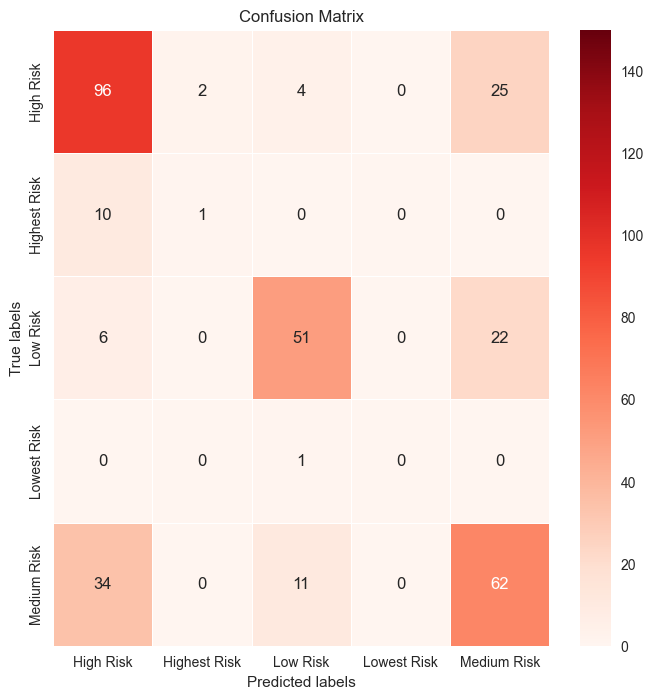

In [25]:
# Create a confusion matrix and display it with seaborn heatmap
cm = confusion_matrix(y_test, predictions_tuned['prediction_label'])
cm_df = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)

fig, ax = plt.subplots(figsize=(8,8))

sns.heatmap(cm_df, annot = True, ax = ax, vmin=0, vmax=150, fmt="d", linewidths=.5, linecolor = 'white', cmap="Reds") # annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 

XgBoost and Random Forest are the best models for ths dataset and it was the ones already used. But pycaret is good for a sanity check in case the data changes.